# Results of simulation of different fairness policies

These experiments use accumulated deficits to try to ensure that applications always receive their computed allocation of GPU time, even in the event of new jobs coming in and old jobs finishing, by keeping track of the difference between the GPU time the application should have received, and the GPU time the application actually received. Allocation of jobs to GPUs is performed in a round-based fashion, with GPUs instructed to run jobs for a fixed interval of time on all GPUs.

# Import statements

In [1]:
# Imports for plotting.
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
rc('text',
   usetex=True)
sns.set_style('ticks')
font = {
    'font.family':'Times New Roman',
    'font.weight': 200,
    'font.size': 10,
}
sns.set_style(font)
flatui = ['#002A5E', '#FD151B', '#8EBA42', '#348ABD', '#988ED5', '#BDB76B', '#8EBA42', '#FFB5B8']
sns.set_palette(flatui)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.bf': 'Times New Roman:bold',
}
sns.set_context("paper", font_scale=2,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Other imports.
import os
import re

# Get logfile paths

In [3]:
def get_logfile_paths_helper(directory_name):
    logfile_paths = []
    for root, _, file_names in os.walk(directory_name):
        if len(file_names) > 0:
            logfile_paths.extend(
                [os.path.join(root, file_name)
                 for file_name in file_names])
    return logfile_paths

def get_logfile_paths(directory_name):
    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/'
             'completion_algo=(\S+)/'
             'measurement_percentage=(\d+\.\d+)/seed=(\d+)/'
             'lam=(\d+\.\d+)\.log', logfile_path)
        if m is None: continue
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        completion_algo = m.group(5)
        measurement_percentage = float(m.group(6))
        seed = int(m.group(7))
        l = float(m.group(8))
        logfile_paths.append((v100s, p100s, k80s, policy,
                              completion_algo, measurement_percentage,
                              seed,
                              l, logfile_path))
    return logfile_paths

In [4]:
all_policies = ["fifo_packed", "max_min_fairness_packed"]
all_completion_algos = ["PMF"]
all_seeds = set([0, 1, 2, 3, 4])
all_measurement_percentages = [0.12, 1.0]
logfile_paths = sorted(get_logfile_paths(
    "/lfs/1/keshav2/gpusched/scheduler/logs/2019-09-04/"))

In [5]:
policy_to_label = {
    "fifo_packed": "FIFO+perf+packed",
    "max_min_fairness_packed": "MMF+perf+packed"
}

# Plotting functions

In [6]:
def prune(logfile_paths, v100s, p100s, k80s, policy,
          completion_algo, measurement_percentage,
          seed=None):
    if seed is None:
        return sorted([(x[7], x[8], x[6]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[4] == completion_algo and
                       0.9 <= x[5] / measurement_percentage <= 1.1])
    else:
        return sorted([(x[7], x[8]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[7] == seed])

In [7]:
def plot_input_job_rate_vs_average_jct(average_jcts, output_filename=None):
    data = {"input_job_rate": [], 'average_jct': [], "seed": [],
            "policy": []}
    policies = sorted(average_jcts.keys())
    for i, policy in enumerate(policies):
        label = policy_to_label[policy]
        for measurement_percentage in average_jcts[policy]:
            for lam in average_jcts[policy][measurement_percentage]:
                input_job_rate = 3600.0 / lam
                for seed in average_jcts[policy][measurement_percentage][lam]:
                    average_jct = average_jcts[policy][measurement_percentage][lam][seed]
                    if average_jct:
                        data["input_job_rate"].append(input_job_rate)
                        data["average_jct"].append(average_jct)
                        data["seed"].append(seed)
                        if measurement_percentage == 1.0:
                            data["policy"].append(label)
                        else:
                            data["policy"].append(label + ' (estimation)')
  
    plt.figure(figsize=(8, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    sns.lineplot(x='input_job_rate', y='average_jct', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)
    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel("Average JCT (hours)")
    sns.despine()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    plt.show()

In [8]:
def plot_input_job_rate_vs_profiling_time(profiling_times, measurement_percentage=0.12, output_filename=None):
    data = {"input_job_rate": [], 'profile_time': [], "seed": [],
            "policy": []}
    policies = sorted(profiling_times.keys())
    for i, policy in enumerate(policies):
        label = policy_to_label[policy] + ' (estimation)'
        for lam in profiling_times[policy][measurement_percentage]:
            input_job_rate = 3600.0 / lam
            for seed in profiling_times[policy][measurement_percentage][lam]:
                profile_time = profiling_times[policy][measurement_percentage][lam][seed]
                if profile_time:
                    data["profile_time"].append(profile_time)
                    data["input_job_rate"].append(input_job_rate)
                    data["seed"].append(seed)
                    data["policy"].append(label)

    plt.figure(figsize=(8, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    sns.lineplot(x='input_job_rate', y='profile_time', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)
    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel("Profiling time (\%)")
    ax.set_ylim(0, 25.0)
    sns.despine()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    plt.show()

# Plot average JCT versus input job rate

In [9]:
def get_average_jct(logfile_path, min_job_id=None, max_job_id=None):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Job (\d+): (\d+\.\d+)', line)
            if m is not None:
                job_id = int(m.group(1))
                job_completion_time = float(m.group(2))
                if min_job_id is None or min_job_id <= job_id:
                    if max_job_id is None or job_id <= max_job_id:
                        job_completion_times.append(
                            job_completion_time)
    if len(job_completion_times) == 0:
        return None
    return np.mean(job_completion_times) / 3600

In [10]:
def get_profiling_time(logfile_path, v100s, p100s, k80s, round_duration=32*60):
    total_profiling_time = 0.0
    total_duration = None
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Profiling these jobs in the next round' in line:
                num_profile_tasks = len(re.findall('\([0-9]*, [0-9]*\)', line))
                total_profiling_time += num_profile_tasks * round_duration
            elif 'Total duration' in line:
                total_duration = float(re.findall('[0-9]*\.[0-9]*', line)[0])
    if total_duration is None:
        return float('inf')
    return 100.0 * total_profiling_time / (total_duration * (v100s + p100s + k80s))

In [11]:
def compute_metric(v100s, p100s, k80s, policies, completion_algo,
                   measurement_percentages, seeds, metric):
    data = {}
    for i, policy in enumerate(policies):
        data[policy] = {}
        for measurement_percentage in measurement_percentages:
            data[policy][measurement_percentage] = {}
            relevant_logfile_paths = list(reversed(prune(
                logfile_paths, v100s, p100s, k80s, policy,
                completion_algo, measurement_percentage)))
            for logfile_path in relevant_logfile_paths:
                lam, path, seed = logfile_path
                if seed not in seeds:
                    continue
                if lam not in data[policy][measurement_percentage]:
                    data[policy][measurement_percentage][lam] = {}
                if metric == 'profiling_time':
                    profiling_time = get_profiling_time(path, v100s, p100s, k80s)
                    if profiling_time is not None:
                        data[policy][measurement_percentage][lam][seed] = profiling_time
                elif metric == 'average_jct':
                    average_jct = get_average_jct(path, min_job_id=4000, max_job_id=5000)
                    if average_jct is not None:
                        data[policy][measurement_percentage][lam][seed] = average_jct
            # If only one inf, remove that data point
            if metric == 'average_jct':
                for lam in data[policy][measurement_percentage]:
                    inf_seeds = []
                    for seed in data[policy][measurement_percentage][lam]:
                        if data[policy][measurement_percentage][lam][seed] == float('inf'):
                            inf_seeds.append(seed)
                    if len(inf_seeds) == 1:
                        for seed in inf_seeds:
                            del data[policy][measurement_percentage][lam][seed]
    return data

V100s=25, P100s=0, K80s=0; Jobs 4000-5000


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


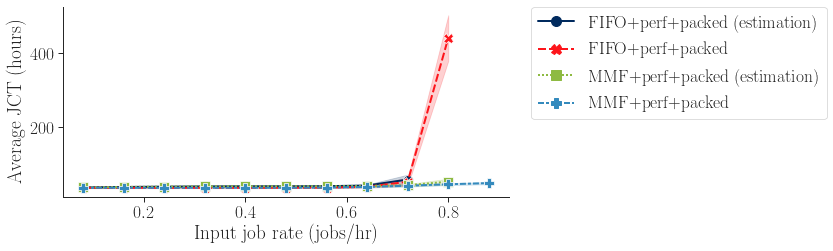

In [12]:
print("V100s=25, P100s=0, K80s=0; Jobs 4000-5000")
# profiling_times = compute_metric(v100s=25, p100s=0, k80s=0,
#                                  policies=all_policies,
#                                  completion_algo='PMF',
#                                  measurement_percentages=[0.12],
#                                  seeds=all_seeds,
#                                  metric='profiling_time')
# plot_input_job_rate_vs_profiling_time(profiling_times)
average_jcts = compute_metric(v100s=25, p100s=0, k80s=0,
                              policies=all_policies,
                              completion_algo='PMF',
                              measurement_percentages=all_measurement_percentages,
                              seeds=all_seeds,
                              metric='average_jct')
plot_input_job_rate_vs_average_jct(average_jcts)

V100s=8, P100s=8, K80s=8; Jobs 4000-5000


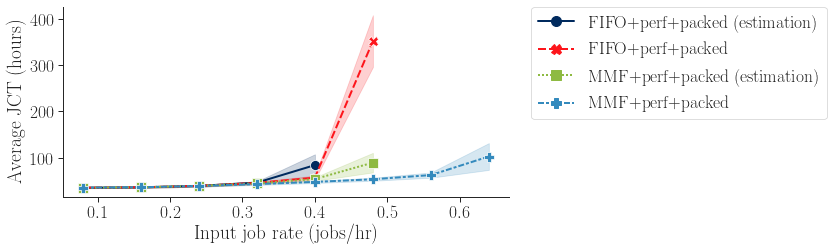

In [13]:
print("V100s=8, P100s=8, K80s=8; Jobs 4000-5000")
# profiling_times = compute_metric(v100s=25, p100s=0, k80s=0,
#                                  policies=all_policies,
#                                  completion_algo='PMF',
#                                  measurement_percentages=all_measurement_percentages,
#                                  seeds=all_seeds,
#                                  metric='profiling_time')
# plot_input_job_rate_vs_profiling_time(profiling_times)
average_jcts = compute_metric(v100s=8, p100s=8, k80s=8,
                              policies=all_policies,
                              completion_algo='PMF',
                              measurement_percentages=all_measurement_percentages,
                              seeds=all_seeds,
                              metric='average_jct')
plot_input_job_rate_vs_average_jct(average_jcts)